#"Will It Learn?" - Tic Tac Toe
The idea is to test your intuition. We will present a problem and then ask you to predict ahead of time whether the network is capable of predicting the output, given the input. 

##Let's start the experiment. 
I was curious if a simple convolutional neural network would find the next best move in a game of tic tac toe. It will be given the board state 4 moves in as an image. It must activate one of 9 neurons to indicate the square of the next best move. This will be taught in a supervised manner, given 50K examples of the next best move. But, will it learn?

Here's a sample image:



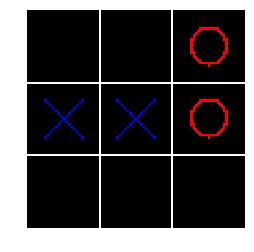

In [1]:
#This is a code cell. Click on the cell to make it active. Then click on the left corner arrow in a circle button to run it. Or use the keyboard shortcut ctlr+enter.
import numpy as np
from PIL import Image, ImageDraw
import random
import matplotlib.pyplot as plt
%matplotlib inline

img_shape = (100, 100, 3)

PLYR_X = 'X'
PLYR_O = 'O'
EMPTY = ' '

def draw_x(draw, coord, sw, sh, color='blue'):
  sz = sw
  x1 = coord[0] - sw / 2
  y1 = coord[1] - sh / 2
  x2 = x1 + sz
  y2 = y1 + sz
  coords = (x1, y1, x2, y2)
  draw.line(coords, fill=color)
  t = y1
  y1 = y2
  y2 = t
  coords = (x1, y1, x2, y2)
  draw.line(coords, fill=color)


def draw_o(draw, coord, sw, sh, color='red'):
  sz = sw
  x1 = coord[0] - sw / 2
  y1 = coord[1] - sh / 2
  x2 = x1 + sz
  y2 = y1 + sz
  coords = (x1, y1, x2, y2)
  draw.ellipse(coords, outline=color)  


def img_tic_tac_toe(img_shape, board_state, squares):
  w = img_shape[1]
  h = img_shape[0]
  img = Image.new('RGB', size=(w, h))
  draw = ImageDraw.Draw(img)
  
  #draw field lines
  for i in range(2):
    horiz = h / 3.0 * (i + 1)
    draw.line((0, horiz, w, horiz), fill='white')

  for i in range(2):
    vert = w / 3.0 * (i + 1)
    draw.line((vert, 0, vert, h), fill='white')
    
  sw = w / 6
  sh = h / 6
      
  for iS, state in enumerate(board_state):
    if state == PLYR_X:
      draw_x(draw, squares[iS], sw, sh)
    elif state == PLYR_O:
      draw_o(draw, squares[iS], sw, sh)
  
  return img


w = img_shape[1]
h = img_shape[0]

squares = []
for j in range(3):
  y = (h * j) / 3 + h / 6.0
  for i in range(3):
    x = (w * i) / 3 + w / 6.0
    squares.append((x, y))
    
def rand_board():
  board_state = [EMPTY for i in range(9)]
  p = PLYR_X
  for i in range(4):
    iS = random.randint(0, 8)
    while board_state[iS] != EMPTY:
      iS = random.randint(0, 8)
    board_state[iS] = p
    if p == PLYR_X:
      p = PLYR_O
    else:
      p = PLYR_X
          
  return board_state

board_state = rand_board()
img = img_tic_tac_toe(img_shape, board_state, squares)
img = np.array(img).astype(np.uint8)
plt.axis('off')
plt.imshow(img)
plt.show()

#You should see an random tic tac toe board.

##What do you think?
Will this somewhat simple network accomplish the task of learning the next best move from just pixels? 


Let's find out...

First let's make sure you are using the GPU. Run the cell bellow to double check:

In [0]:
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#if you see something like '/device:GPU:0' then the gpu accelerated learning will be enabled. if not, cpu will work, just slower.

##Our Neural Network

Here's what our network will look like. Pretty straight foward, 4 layers of convolutions. 64 filters per layer. A 3x3 kernel used in each. With relu activation in each. 

In [2]:
#Let's define a pretty straight forward conv neural network. It will have about 200K params, given the input image dimension of 100 x 100
import keras
from keras.layers import Flatten, Conv2D, Dense

max_circles = 10
img = keras.Input(shape=img_shape)

x = img
x = Conv2D(64, (3, 3), strides=(2,2), activation="relu")(x)
x = Conv2D(64, (3, 3), strides=(2,2), activation="relu")(x)
x = Conv2D(64, (3, 3), strides=(2,2), activation="relu")(x)
x = Conv2D(64, (3, 3), strides=(2,2), activation="relu")(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dense(9, activation='softmax')(x)

model = keras.Model(img, x)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
print(model.summary())

Using TensorFlow backend.
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/pi/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-5429e90511d7>", line 2, in <module>
    import keras
  File "/usr/local/lib/python3.5/dist-packages/keras/__init__.py", line 3, in <module>
    from . import utils
  File "/usr/local/lib/python3.5/dist-packages/keras/utils/__init__.py", line 6, in <module>
    from . import conv_utils
  File "/usr/local/lib/python3.5/dist-packages/keras/utils/conv_utils.py", line 9, in <module>
    from .. import backend as K
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/__init__.py", line 89, in <module>
    from .tensorflow_backend import *
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 5, in <module>
    import tensorflow as tf
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/__init__.py", line 22, in <module>
   

KeyboardInterrupt: 

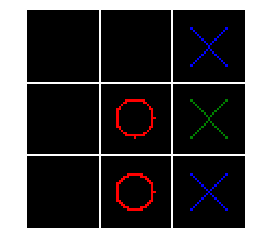

In [3]:
#some board routines from https://github.com/navdeeshahuja/Python-TicTacToe-Best-Move-Generator-Artificial-Intelligence-Minimax
#I've fixed some bugs, so this is slightly modified from that source
def checkWin(board, player):
    for i in range(0, 7, 3):
        if(board[i] == player and board[i+1] == player and board[i+2] == player):
            return True
    for i in range(0, 3):
        if(board[i] == player and board[i+3] == player and board[i+6] == player):
            return True
    if(board[0] == player and board[4] == player and board[8] == player):
        return True
    if(board[2] == player and board[4] == player and board[6] == player):
        return True
    return False

def checkLose(board, player):
    if(player == PLYR_X):
        opponent = PLYR_O
    else:
        opponent = PLYR_X
    if(checkWin(board, opponent)):
        return True
    return False

def checkTie(board):
    for x in board:
        if(x == EMPTY):
            return False
    return True
    

def getAIMove(board, nextMove, aiPlayer, depth=0):
    if(checkWin(board, aiPlayer)):
        return (-1, 11 - depth)
    elif(checkLose(board, aiPlayer)):
        return (-1, -11 + depth)
    elif(checkTie(board)):
        return (-1, 0)

    moves = []
    
    for i in range(len(board)):
        if(board[i] == EMPTY):
            board[i] = nextMove
            
            score = getAIMove(board, (PLYR_X if nextMove == PLYR_O else PLYR_O), aiPlayer, depth + 1)[1]
            moves.append((i, score))
            #print(nextMove, moves)
            board[i] = EMPTY

    
    if(nextMove == aiPlayer):
        maxScore = moves[0][1]
        bestMove = moves[0]
        for move in moves:
            if(move[1] > maxScore):
                bestMove = move
                maxScore = move[1]
        return bestMove
    else:
        minScore = moves[0][1]
        worstMove = moves[0]
        for move in moves:
            if(move[1] < minScore):
                worstMove = move
                minScore = move[1]
        return worstMove
      
def best_move_for_x(board_state):
  iSquare, score = getAIMove(board_state, PLYR_X, PLYR_X)
  one_hot = np.zeros(9)
  one_hot[iSquare] = 1
  return one_hot, iSquare, score

#Test the routines above by generating a random board and finding the bext move.
board_state = rand_board()
img = img_tic_tac_toe(img_shape, board_state, squares)
one_hot, iSquare, score = best_move_for_x(board_state)
sw = w / 6
sh = h / 6
draw = ImageDraw.Draw(img)
draw_x(draw, squares[iSquare], sw, sh, color='green')
img = np.array(img).astype(np.uint8)
plt.axis('off')
plt.imshow(img)
plt.show()
#here the green x will show the next best move for x.


In [4]:
# Here's function that will generate a numpy array of images and moves for our NN to train on
def generator(img_shape, batch_size, squares):
  while True:
    X = []
    y = []
    for i in range(batch_size):
      board_state = rand_board()
      img = img_tic_tac_toe(img_shape, board_state, squares)
      move, iSquare, score = best_move_for_x(board_state)
      img = np.array(img).astype(np.uint8)
      X.append(img)
      y.append(move)
    yield np.array(X), np.array(y)



In [5]:
#Now let's start the training.

# batch_size = 64
# steps_per_epoch = 256
# epochs = 2

# train_gen = generator(img_shape, batch_size, squares)

# model.fit_generator(train_gen, 
#                     steps_per_epoch=steps_per_epoch, 
#                     epochs=epochs, 
#                     verbose=1)

from keras.models import load_model
model = load_model("tictactoe.h5")
print ("model loaded, hic")


Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.4 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 432, got 412
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 56, got 52
  return f(*args, **kwds)


NameError: name 'core' is not defined

In [0]:
#Now let's create a new image and see how it does.
#Run this multiple times to get a feeling about how it handles different cases.

board_state = rand_board()
img = img_tic_tac_toe(img_shape, board_state, squares)
img_arr = np.array(img).astype(np.uint8)
res = model.predict(img_arr[None, :, :, :])
#print("raw prediction: ", res[0])
iSquare = np.argmax(res[0])
print("square", iSquare, "confidence", res[0][iSquare])
draw = ImageDraw.Draw(img)
draw_x(draw, squares[iSquare], sw, sh, color='green')
plt.axis('off')
plt.imshow(img)
plt.show()
#here the green x will show the next best move for x.


#So What's Your Verdict?
Do you think this learned to find the next best square for X?

In my opinion, it was far better than expected. It was not clear at all that it would handle the cases where a win would beat a block. Or find the move that would give it two ways to win. I've seen many cases where it handled it quite well. I didn't spot any cases where it failed.

#Further thought..
Is this domain just so small it simply memorized all posiblities? How about a connect 4 with an 8 x 8 board. This was just always the 5th move in. Could it learn to play the entire game?

#Episodes Links:

[Will It Learn? - S01E01 Circle Count](https://drive.google.com/open?id=11EiFFa-imh5MNEPJZuqgqJAwLYHhP3gG)

[Will It Learn? - S01E02 Tic Tace Toe](https://drive.google.com/open?id=1PKosDR9wcgPaF2-BYMSZiu2nW03COxma)

[Will It Learn? - S01E03 : Shell Game](https://drive.google.com/open?id=163iv-LaidgxiU3tT_RcLCT_K1HOdagMu)

[Will It Learn? - S01E04 : Word Jumble](https://drive.google.com/open?id=19ENSHOC-TEyDqZ-_47QhSHHxhUAuDEoA)

[Will It Learn? - S01E05 : Mazes](https://drive.google.com/open?id=1qdYWNwrmYAtFsayzoxPuuGAE1RTKt1ia)


